In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import floor
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pd.set_option('display.max_rows', 100)
base = '/home/ana/Downloads/'
sns.set_theme(style="whitegrid")
fig_dim = (15,12)

Using TensorFlow backend.


In [2]:
# Auxiliar Functions
def bar_plot(_x, _y, _data):
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x=_x, y=_y, data=_data)
    plt.xticks(rotation=90)
    plt.draw()

Notas: A nossa solução inicial assumia que era possível fazer o tracing das bicicletas, mas após ser fornecido o dicionário, percebemos que tal não era possível dado que "The same bike can have multiple tags over the year".

# JUNTAR A PARTE DA CAROLINA - LIMPEZA

Explicar o que foi limpo e justificar. (RESUMO)

In [3]:
def get_loans_clean(base):

    df = pd.read_pickle(base + 'df_clean')[["Id_Historico_Prestamo", "Id_Usuario", "Id_Tag_Bicicleta", \
            "Fecha_Prestamo", "Fecha_Devolucion", "Id_Aparcamiento_Origen", "Posicion_Origen", \
            "Id_Aparcamiento_Destino", "Posicion_Destino"]]
    
    # Rename columns
    # The same bike can have multiple tags over the year.
    df = df.rename(columns={
        "Id_Historico_Prestamo": "Loan ID",
        "Id_Usuario": "User ID",
        "Id_Tag_Bicicleta": "Tag ID",
        "Fecha_Prestamo": "Start loan",
        "Fecha_Devolucion": "End loan",
        "Id_Aparcamiento_Origen": "ID start station",
        "Posicion_Origen": "Position start",
        "Id_Aparcamiento_Destino": "ID end station",
        "Posicion_Destino": "Position end"
    })
    
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df["End loan"] = pd.to_datetime(df["End loan"], format='%Y-%m-%d %H:%M:%S.%f')
    
    # Auxiliar fields
    df['year_prestamo'] = df["Start loan"].dt.year # Start loan
    df['month_prestamo'] = df["Start loan"].dt.month
    df['day_prestamo'] = df["Start loan"].dt.day
    df['hour_prestamo'] = df["Start loan"].dt.hour
    
    df['duration_hour'] = (df["End loan"]-df["Start loan"]).dt.total_seconds().div(60*60)
    df['Fecha_Prestamo_htruncate'] = df['Start loan'].dt.floor('h')
    
    return df

df = get_loans_clean(base)
df.head()

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end,year_prestamo,month_prestamo,day_prestamo,hour_prestamo,duration_hour,Fecha_Prestamo_htruncate
0,6501462,18701,1164,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,2017,6,21,14,0.271667,2017-06-21 14:00:00
1,6501318,41811,1089,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,2017,6,21,14,0.530000,2017-06-21 14:00:00
2,6501489,96620,1110,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,2017,6,21,14,0.232222,2017-06-21 14:00:00
3,6501001,16055,1465,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,2017,6,21,13,1.058333,2017-06-21 13:00:00
4,6501421,6431,996,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,2017,6,21,14,0.358333,2017-06-21 14:00:00


Stations information

# VER SE ALGUEM PRECISA DE OUTROS CAMPOS

In [4]:
df_info = pd.read_csv("station_location_with_id.csv", sep=';')[['ID','numSlots','isManual']]
df_info.head()

,ID,numSlots,isManual
0,1,15,1
1,2,33,1
2,3,40,0
3,4,10,1
4,5,33,1


Quais são as horas/dias da semana/meses mais comuns para usar uma bicicleta?

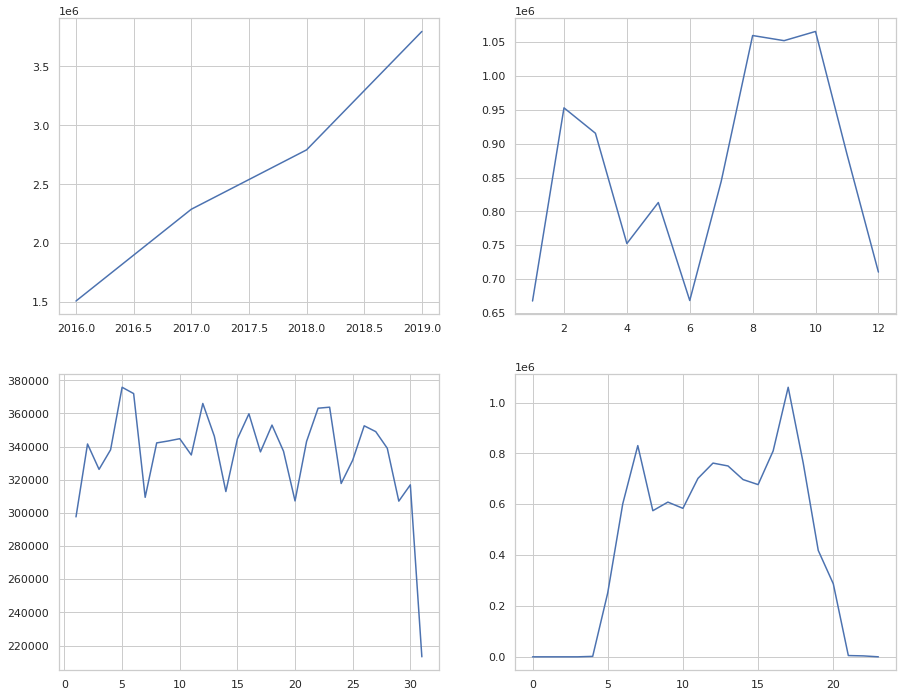

In [5]:
def plot_prestamo_over_time(_df):
    df = _df.copy()
    
    fig, axs = plt.subplots(2, 2, figsize=fig_dim)
    axis = [ axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
    
    time_units = ["year", "month", "day", "hour"]
    
    for i in range(len(time_units)):
        time_unit = time_units[i]
        df_time = df.groupby(time_unit+'_prestamo').size().reset_index(name='count')

        axis[i].plot(df_time[time_unit+"_prestamo"], df_time["count"])

    plt.plot()

plot_prestamo_over_time(df)

Quais é que são os tempos médios de empréstimo?

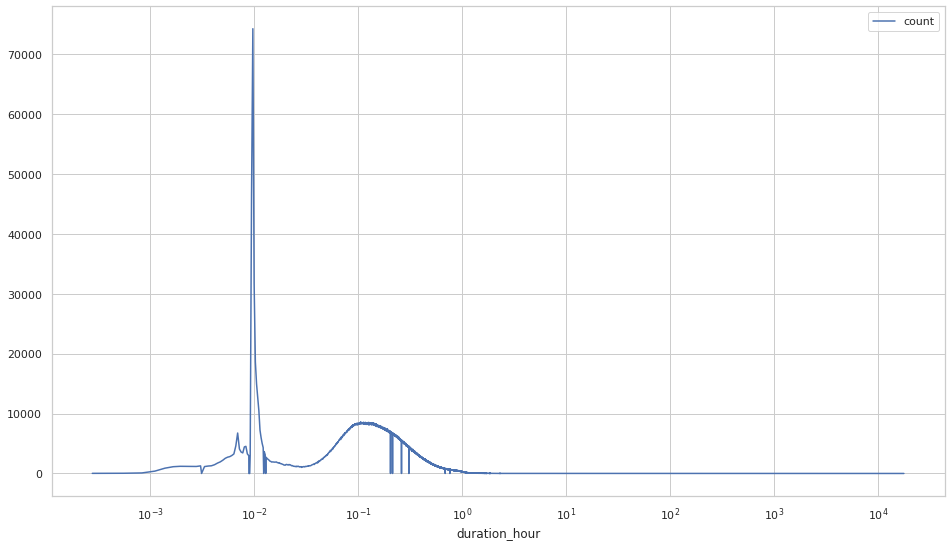

In [6]:
dfDuration=df.groupby('duration_hour').size().reset_index(name='count')
ax=dfDuration.plot(x="duration_hour", y="count", figsize=(16,9))
ax.set_xscale('log')

Quais as origens/destinos mais comuns

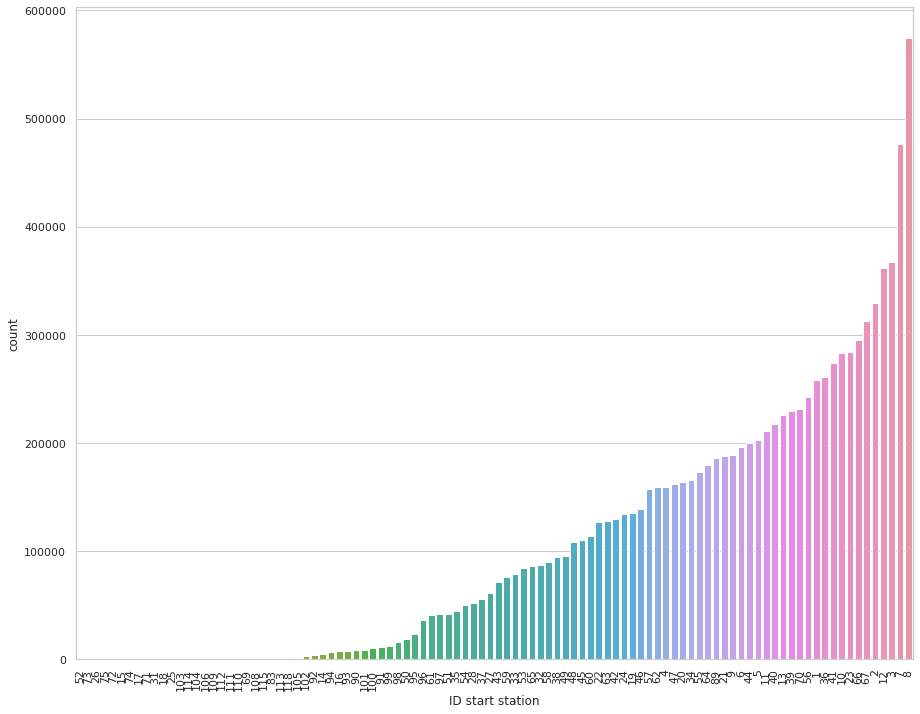

In [8]:
dfOrigin=df.groupby('ID start station').size().reset_index(name='count').sort_values(by=['count'])    
dfOrigin["ID start station"] = dfOrigin["ID start station"].astype(str)
bar_plot("ID start station", "count", dfOrigin)

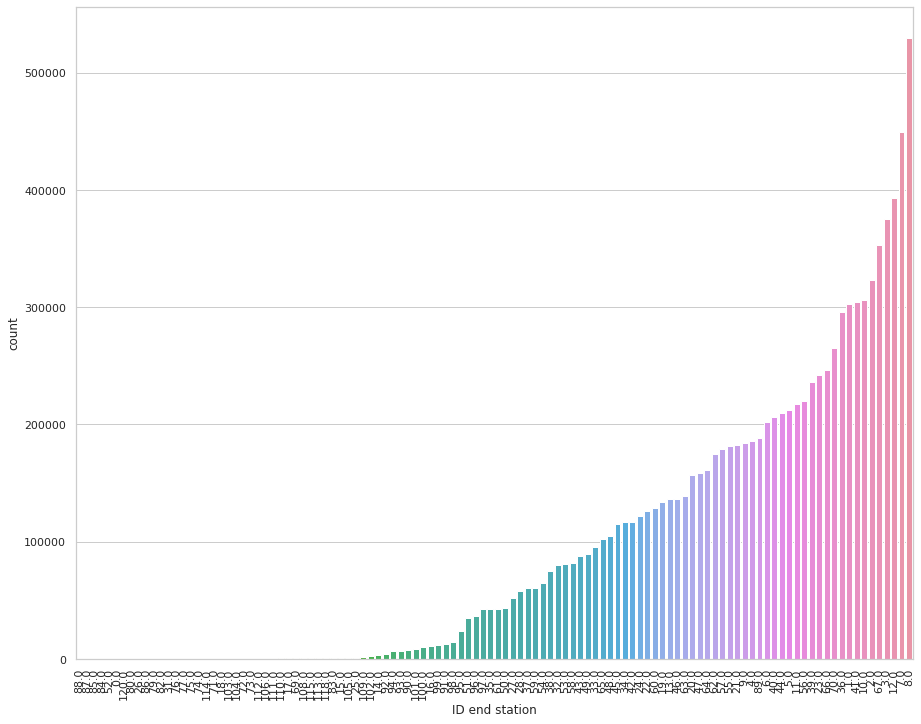

In [9]:
dfDestination=df.groupby('ID end station').size().reset_index(name='count').sort_values(by=['count'])    
dfDestination["ID end station"] = dfDestination["ID end station"].astype(str)
bar_plot("ID end station", "count", dfDestination)

Quais os trajetos mais comuns?

In [11]:
dfTranjects=df.groupby(['ID start station', 'ID end station']).size().reset_index(name='count')
dfTranjects.head()

,ID start station,ID end station,count
0,1,1.0,18469
1,1,2.0,62067
2,1,3.0,28127
3,1,4.0,9198
4,1,5.0,674


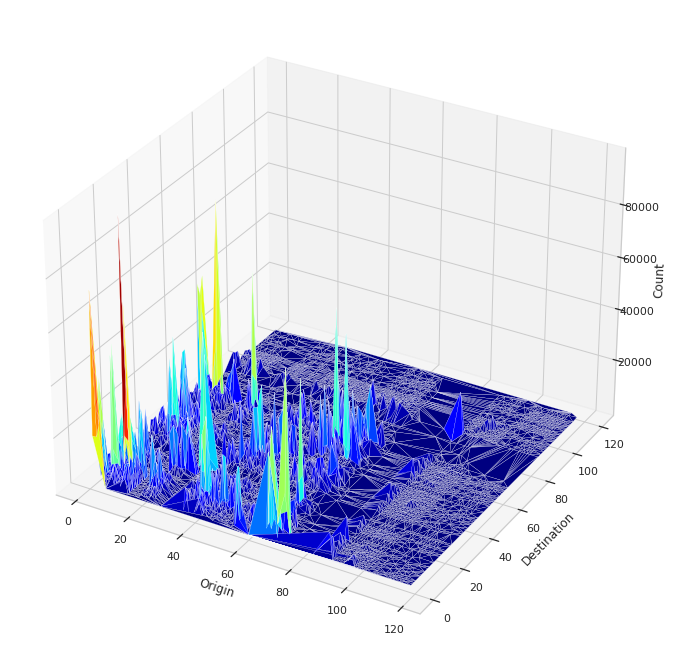

In [12]:
fig = plt.figure(figsize=(16, 9))
ax = Axes3D(fig)

ax.plot_trisurf(dfTranjects["ID start station"], dfTranjects["ID end station"], \
                dfTranjects["count"], cmap=cm.jet, linewidth=0.2)
ax.set_zlabel('Count')
ax.set_xlabel('Origin')
ax.set_ylabel('Destination')

plt.show()

In [14]:
unique_parks = df['ID start station'].unique()
unique_parks

array([  8,  56,  36,  22,  19,  21,  47,  45,  46,  65,  39,  55,  11,
        44,   2,  62,  10,   3,  34,  41,   6,  43,  58,  38,   7,  67,
        13,  60,  23,  40,  63,  66,   1,   4,   9,  51,  12,  70,  69,
        24,  16,  64,  59,  33,  42,  57,  27,  61,  48,  20,  35,  37,
         5,  32,  49,  54,  28,  53,  17,  14,  52,  31,  25,  15,  89,
        26,  50,  83,  72,  74,  71,  73,  75,  91,  94,  90,  18,  97,
        95,  96,  93,  98, 100,  99, 101, 102,  92, 113, 109, 108, 118,
       114, 105, 112, 111, 103, 104, 115, 106, 110])

Para cada nó, as datas/dias e a contagem do check-in (empréstimos).

In [16]:
dfOrigemDayCount=df.groupby(["ID start station", pd.Grouper(key="Fecha_Prestamo_htruncate", freq="D")]) \
                        .size().reset_index(name='Count')
dfOrigemDayCount.head()

,ID start station,Fecha_Prestamo_htruncate,Count
0,1,2016-01-04,71
1,1,2016-01-05,85
2,1,2016-01-06,71
3,1,2016-01-07,97
4,1,2016-01-08,87


In [44]:
# nº de nós associados ao dia
dfNodesDay = dfOrigemDayCount.groupby("Fecha_Prestamo_htruncate").size().reset_index() \
    .rename(columns={0:'count'}).sort_values(by=['count'])

dfNodesDay.tail()

,Fecha_Prestamo_htruncate,count
1160,2019-12-30,84
1157,2019-12-26,84
1158,2019-12-27,84
1159,2019-12-28,84
1154,2019-12-23,85


Isto dá-nos a data com mais nós associados mas não garante que os 85 nós tem 4 entradas antes

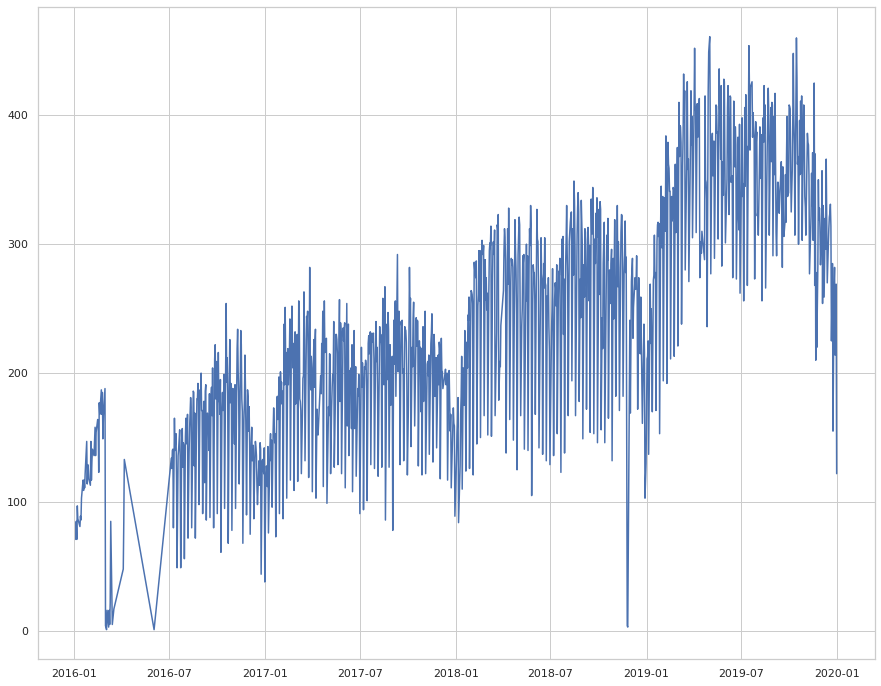

In [28]:
def loans_per_day_per_station(_df, station):
    df = _df.copy()
    df = df[df["ID start station"]==station]
    df = df[["Fecha_Prestamo_htruncate", "Count"]]
    
    fig = plt.figure(figsize=fig_dim)
    plt.plot(df["Fecha_Prestamo_htruncate"], df["Count"])

loans_per_day_per_station(dfOrigemDayCount, 1)

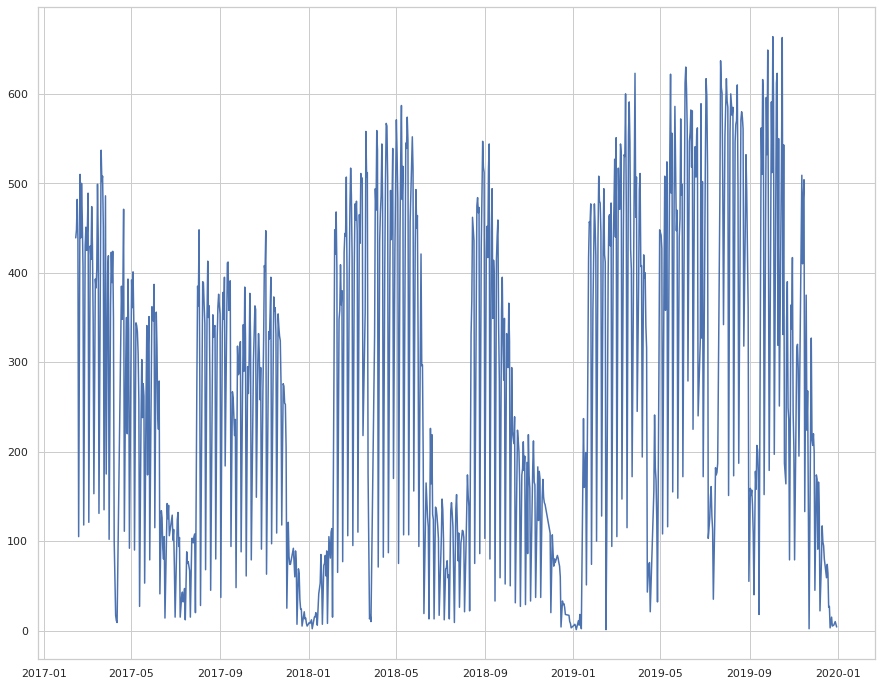

In [29]:
loans_per_day_per_station(dfOrigemDayCount, 70)

Loans per station per hour

In [17]:
def get_loans_or_returns_per_station_per_hour(_df, field_date, field_station, field_position):
    df = _df.copy()
    df = df[[field_date, field_station, field_position]]
    df[field_position] = [1]*len(df.index)
    df[field_date] = df[field_date].dt.round("1H")
    df = df.rename(columns={field_date:'Date', field_station:'Station'})
    df = df.groupby(['Station', 'Date']).count()
    
    if(field_date=='Start loan'):
        df = df.rename(columns={field_position:'N Loans'})
    else:
        df = df.rename(columns={field_position:'N Returns'})
        
    return df

def get_loans_and_returns_info(_df):
    loans = get_loans_or_returns_per_station_per_hour(_df, \
                    'Start loan', 'ID start station', 'Position start')
    
    returns = get_loans_or_returns_per_station_per_hour(_df, \
                    'End loan', 'ID end station', 'Position end')
    
    df = pd.concat([loans, returns], axis=1)
    df = df.fillna(0)
    
    return df

loans_and_returns = get_loans_and_returns_info(df)
loans_and_returns.head(5)

N Loans  N Returns
Station Date                                   
0.0     2017-10-03 22:00:00      0.0        1.0
        2018-03-21 11:00:00      0.0        1.0
        2018-03-21 18:00:00      0.0        1.0
1.0     2016-01-04 06:00:00      5.0        1.0
        2016-01-04 07:00:00     11.0        2.0

In [18]:
# Given a station, this function calculates the number of bikes through time using the loans and the returns
def get_balance_for_station(_df, station):
    df = _df.copy()
    df = df.reset_index()
    df = df.loc[df['Station']==station]
    df['N Loans cumsum'] = df['N Loans'].cumsum()
    df['N Returns cumsum'] = df['N Returns'].cumsum() # returns
    df['Balance'] = df['N Returns cumsum'] - df['N Loans cumsum']
    
    return df

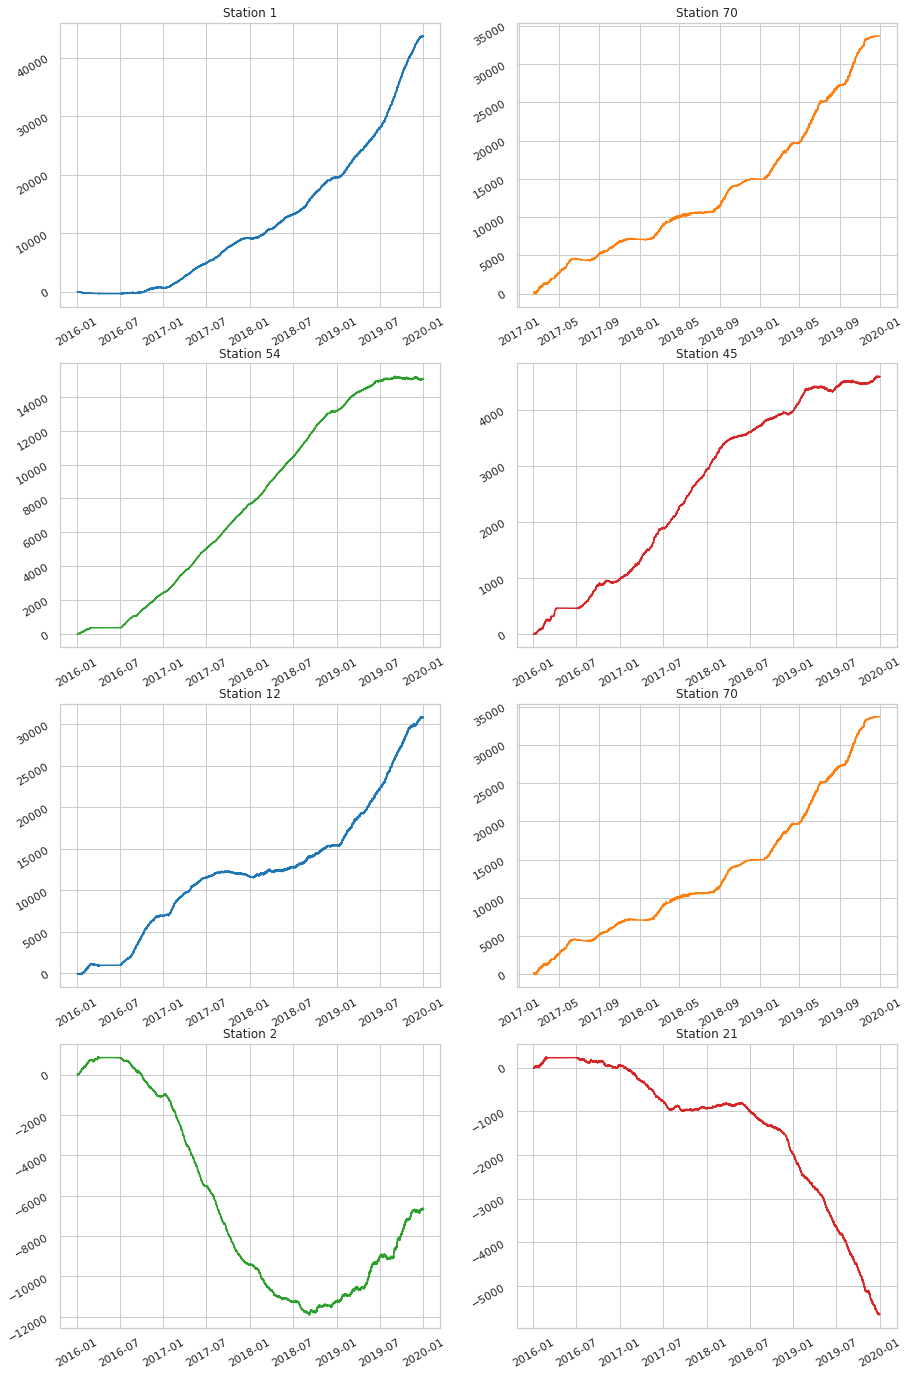

In [19]:
def plot_balance_over_multiple_stations(loans_and_returns, stations):
    
    fig, axs = plt.subplots(4, 2, figsize=(15,24))
    axis = [ axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1],
             axs[2, 0], axs[2, 1], axs[3, 0], axs[3, 1]]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i in range(8):
        station = stations[i]
    
        balance_st = get_balance_for_station(loans_and_returns, station)
        
        axis[i].plot(balance_st['Date'], balance_st['Balance'], colors[i])
        axis[i].set_title('Station ' + str(station))
        axis[i].tick_params(labelrotation=30)

    plt.plot()

plot_balance_over_multiple_stations(loans_and_returns, stations=[1, 70, 54, 45, 12, 70, 2, 21])

Dizer o que significa as subidas, descidas e estabilizações - recebm mais do que emprestam, emprestam mais do que receber e recebem e emprestam na mesma porporção (respetivamente)
Através do balanço não dá para perceber qual o número de bicicletas inicial da estação, porque esistem várias trocas manuais que não são reportadas.

In [20]:
# TO-DO
# gráfico
# após a previsão encontrar o dia com mais nós em que foi realizada a previsão

Obter o número inicial de bicicletas por estação

In [21]:
# ver o primeiro mês em que a estação abre, e fazer a contagens por aí

def get_init_number_of_bikes_per_station(_df):
    df = _df.copy()
    df = df[["Tag ID", "Start loan", "ID start station"]]
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.sort_values(by="Start loan")
    # for each tag get first station
    df = df.groupby("Tag ID").first() \
            .reset_index() \
            [["Tag ID", "ID start station"]]
    # for each station get initial number of bikes 
    df = df.groupby("ID start station").count()
    df = df.rename(columns={'Tag ID':'Count'})
    df = df.sort_values(by=['Count'])
    df = df.reset_index()
    df["ID start station"] = df["ID start station"].astype(str)
    return df
    
init_n_bikes = get_init_number_of_bikes_per_station(df)
init_n_bikes.head()

,ID start station,Count
0,89,1
1,96,1
2,99,1
3,25,1
4,106,1


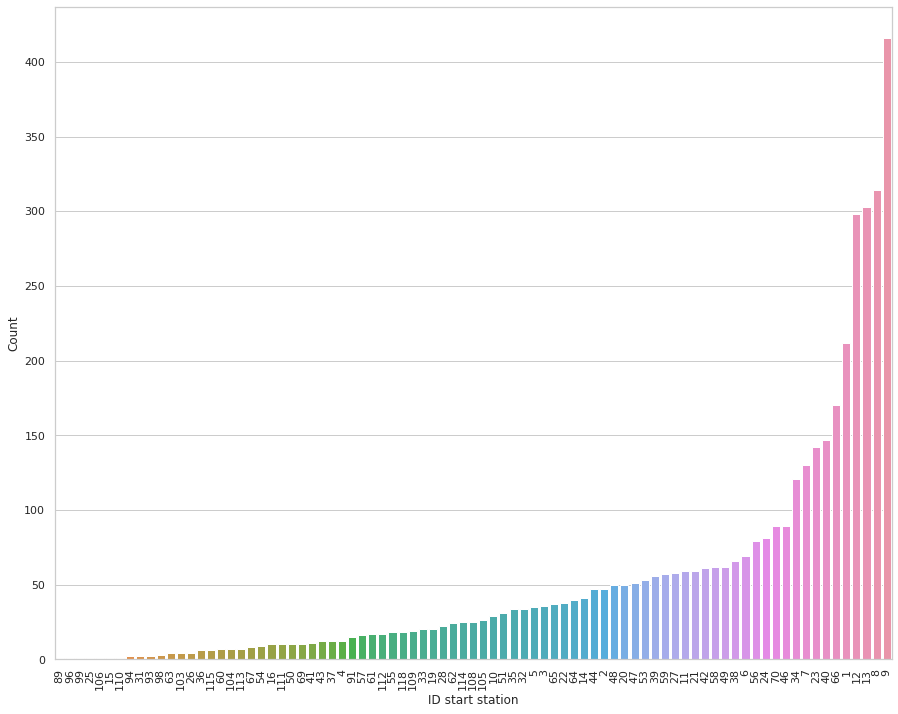

In [22]:
fig, axs = plt.subplots(figsize=fig_dim)
axs = sns.barplot(x="ID start station", y="Count", data=init_n_bikes)
plt.xticks(rotation=90)
plt.draw()

The figure above represents the number of bikes that appear for the first time in each station

A estação 9 está associada ao aparecimento pela primeira vez de 400 bicicletas (do ID de uma bicicleta).

[BRUNO] Qual é a localização das estações com mais de 100 contagens? 

Verificar quando as estações automáticas cheias. -> ver para cada estação qual o nº máximo de posições diferentes e depois tentar perceber qnd é que elas estão cheias (elas estão cheias se num dado intervalo de tempo todas as positions estão ocupadas) ---> taxa de ocupação

Há posições que nunca são ocupadas!!!!

Ver a taxa de ocupação a cada hora

Ver a capacidade de armazenamento das estações automáticas. Quais são as estações automáticas com maior capacidade de armazenamento? Quais as com menor?

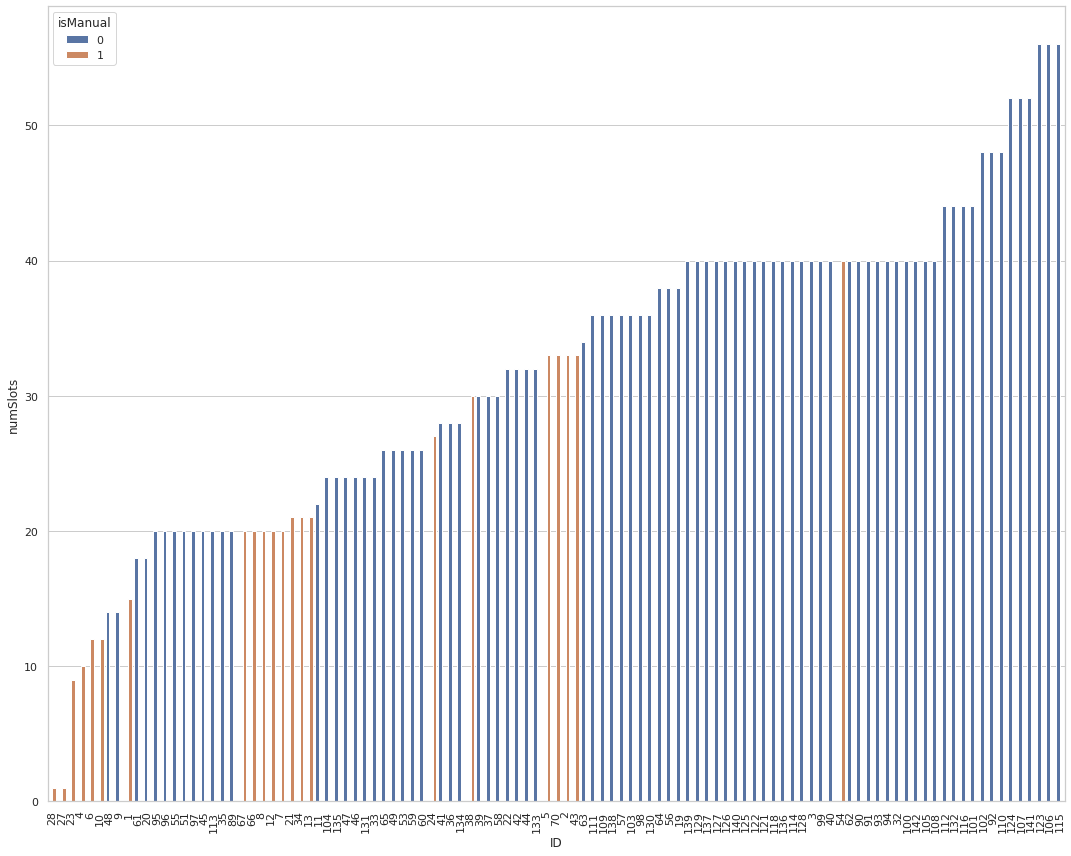

In [24]:
def capacity_per_station(_df):
    df = _df.copy()
    df["ID"] = df["ID"].astype(str)
    df = df.sort_values(by=['numSlots'])
    
    fig, axs = plt.subplots(figsize=(15,12))
    axs = sns.barplot(x="ID", y="numSlots", hue="isManual", data=df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.draw()
    
capacity_per_station(df_info)

É possivel vizualizar que as estações manuais existem em menor quantidade que as automáticas...

# Previsão

In [ ]:
# ver parâmetros para melhorar, 
# se o count_before for 8 ele dá 8 entradas antes
# offset é o nº de dias antes do atual
# distância entre cada uma das entradas
# distance=1, count_before=3, offset=0 ---> considera os 3 dias antes
# distance=7, count_before=4, offset=7 ---> 4 entradas com a diferença de 7 dias entre elas 
#                                              e começo a contar na semana anterior

In [30]:
# Auxiliar functions
def generate_features(df, cols, distance=1, count_before=3, offset=0):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance+offset)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for col in cols:
        for i in range(0, count_before):
            diff=(i+1)*distance+offset
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], \
                                                               axis=1) 
        
    return periodDf

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test):
    trainX = train[dfFeatures.columns[4:]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[["Count"]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[dfFeatures.columns[4:]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[["Count"]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    min_score=-1
    min_model=None
    # repeat experiment
    scores = list()
    for r in range(repeats):
        print("Train #{}....".format(r))
        model, score = evaluate_model(trainX, trainy, testX, testy)
        if min_score==-1 or score<min_score:
            min_score=score
            min_model=model
        scores.append(score)
    return min_model, scores

In [45]:
allNodesDf=pd.DataFrame()
# CREATE MODEL PER NODE AND PREDICT TEST SET BASED ON EACH INDIVIDUAL MODEL
for park in unique_parks:
    # FILTERING ENTRIES TO PARK ID
    print ("Filtering entries by park id {}...".format(park))
    dfParkId = dfOrigemDayCount[dfOrigemDayCount["ID start station"]==park]
    dfParkId=dfParkId.reset_index()
    
    # GENERATE FEATURES (4 ENTRIES 7 DAYS APPART FROM EACH OTHER FROM THE PREVIOUS 4 WEEKS)
    print ("Generating park {} features...".format(park))
    dfFeatures=generate_features(dfParkId, ["Count"], distance=7, count_before=4, offset=7)
    dfFeatures=dfFeatures.reset_index(drop=True)

    # SPLITTING DF INTO TRAIN AND TEST SETS
    print ("Splitting train/test dataset for park id {}...".format(park))
    train, test = split_df(dfFeatures)
    trainX, trainy, testX, testy = process_df(train, test)
    
    # TRAIN CNN
    print ("Traning model for park id {}...".format(park))
    model, scores = run_experiment(trainX, trainy, testX, testy, repeats=3)
    
    # PREDICT TEST SET SAMPLES
    print ("Predicting samples for park id {}...".format(park))
    predict = model.predict(testX)
    dfPredict=pd.DataFrame(data=predict.flatten()[:], columns=["predict"])
    truth=pd.DataFrame(data=testy[:], columns=["truth"])
    testDf=pd.concat([dfPredict, truth, test.reset_index()[["ID start station", "Fecha_Prestamo_htruncate"]]], \
                     axis=1)
    testDf.set_index(["ID start station", "Fecha_Prestamo_htruncate"], inplace = True)
    allNodesDf=pd.concat([allNodesDf, testDf])
    print(allNodesDf)

Filtering entries by park id 8...
Generating park 8 features...
Splitting train/test dataset for park id 8...
Traning model for park id 8...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 8...
                                              predict  truth
ID start station Fecha_Prestamo_htruncate                   
8                2019-04-13                590.375183    422
                 2019-04-15                640.814758    531
                 2019-04-16                716.547180    495
                 2019-04-17                691.249756    457
                 2019-04-22                830.418945    604
...                                               ...    ...
                 2019-12-26                578.774841    372
                 2019-12-27                531.316101    392
                 2019-12-28                500.427460    224
                 2019-12-30                597.534729    314
                 2019-12-31                569.10559

KeyboardInterrupt: 

# Overall results

OVERALL ROOT MEAN SQUARED ERROR >> 175.01339378455086
 ------------------ NODE 8 TRUTH VS PREDICTED CHECK INS ------------------ 


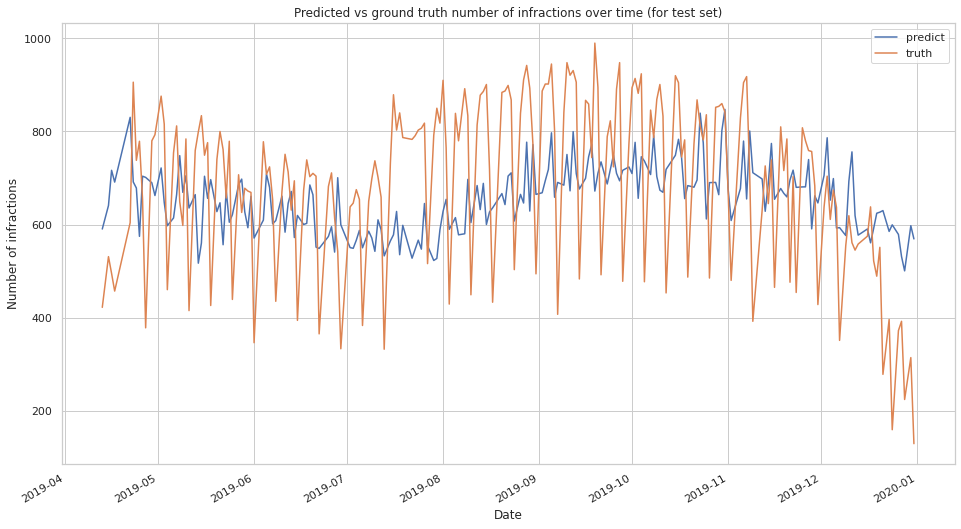

 ------------------ NODE 56 TRUTH VS PREDICTED CHECK INS ------------------ 


KeyError: 56

In [46]:
rms = np.sqrt(mean_squared_error(allNodesDf["truth"], allNodesDf["predict"]))
print ("OVERALL ROOT MEAN SQUARED ERROR >> " + str(rms))

for node in unique_parks:
    print (" ------------------ NODE {} TRUTH VS PREDICTED CHECK INS ------------------ ".format(node))
    ax=allNodesDf.loc[node].plot(figsize=(16,9), title='Predicted vs ground truth number of infractions over time (for test set)')

    ax.set_xlabel("Date")
    ax.set_ylabel("Number of infractions")
    plt.show()